In [1]:
%cd ../..

/home/work/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data

from combinators.inference import conditioning, variational
from combinators.lens import Cap, PRO, Ty
from combinators.model import collections
from combinators import sampler, signal, utils


In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = 3
particle_shape = (num_particles,)
batch_shape = (1,)

In [8]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [9]:
def accumulate_trajectory(p):
    initial_position = p['position_0'].value
    initial_velocity = p['velocity_0'].value
    velocities = torch.zeros(*initial_velocity.shape[:2], T + 1, 2)
    velocities[:, :, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, :, t] = p['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, :, 0, :]

In [10]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [11]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [12]:
def graph_inferred_trajectory(positions, T, s, show=True):
    positions = positions.squeeze(dim=0)
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [13]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))
    
    velocity_steps = velocity_steps.squeeze(-2)
    displacements = displacements.squeeze(-2)

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [14]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [15]:
def training_model():
    init_dynamics = dynamical_ball.InitBallDynamics()
    update = dynamical_ball.InitDynamicsProposal()
    init_dynamics = sampler.importance_box('init_dynamics', init_dynamics, update,
                                           batch_shape, particle_shape, PRO(0), PRO(2))
    init_state = dynamical_ball.InitialBallState()
    update = dynamical_ball.InitBallProposal()
    init_state = sampler.importance_box('init_state', init_state, update,
                                        batch_shape, particle_shape,
                                        PRO(0), PRO(2))
    
    step = dynamical_ball.StepBallState()
    update = dynamical_ball.StepBallProposal()
    step = sampler.importance_box('step_state', step, update, batch_shape, particle_shape, PRO(4), PRO(2))
    step = collections.parameterized_ssm(PRO(2), PRO(2), step)
    
    return (init_state @ init_dynamics) >> collections.sequential(step, T)

02/23/2022 10:26:32 elbo=-7.44211792e+02 at epoch 1
02/23/2022 10:26:34 elbo=-4.76344116e+02 at epoch 2
02/23/2022 10:26:35 elbo=-5.30440186e+02 at epoch 3
02/23/2022 10:26:37 elbo=-4.87605194e+02 at epoch 4
02/23/2022 10:26:38 elbo=-4.41364075e+02 at epoch 5
02/23/2022 10:26:40 elbo=-4.78400055e+02 at epoch 6
02/23/2022 10:26:41 elbo=-4.14446106e+02 at epoch 7
02/23/2022 10:26:42 elbo=-4.17445862e+02 at epoch 8
02/23/2022 10:26:44 elbo=-4.28175629e+02 at epoch 9
02/23/2022 10:26:45 elbo=-3.68447876e+02 at epoch 10
02/23/2022 10:26:48 elbo=-3.70475952e+02 at epoch 11
02/23/2022 10:26:49 elbo=-4.03957977e+02 at epoch 12
02/23/2022 10:26:51 elbo=-4.76351715e+02 at epoch 13
02/23/2022 10:26:52 elbo=-4.66527069e+02 at epoch 14
02/23/2022 10:26:53 elbo=-4.07677948e+02 at epoch 15
02/23/2022 10:26:55 elbo=-3.54676178e+02 at epoch 16
02/23/2022 10:26:56 elbo=-4.14519623e+02 at epoch 17
02/23/2022 10:26:58 elbo=-3.42665527e+02 at epoch 18
02/23/2022 10:26:59 elbo=-3.27896454e+02 at epoch 19
02

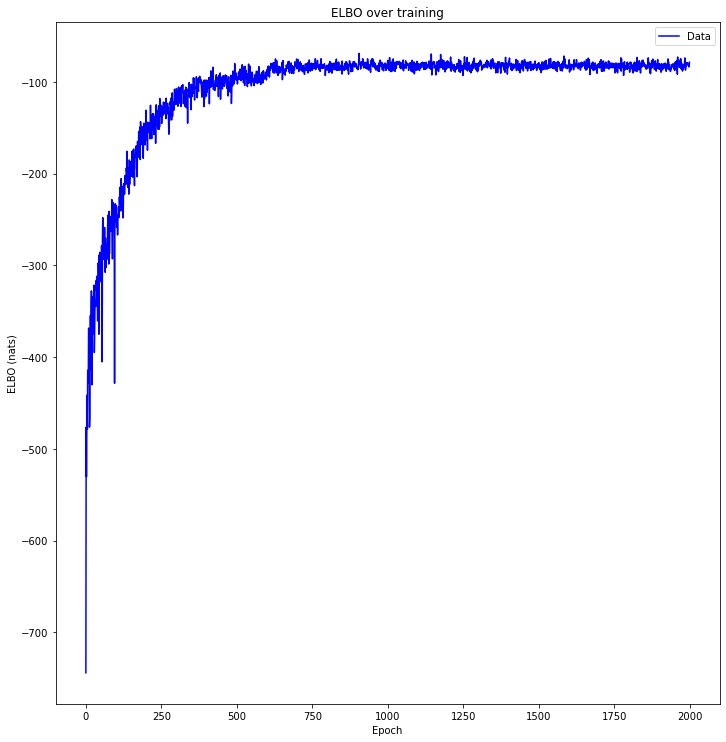

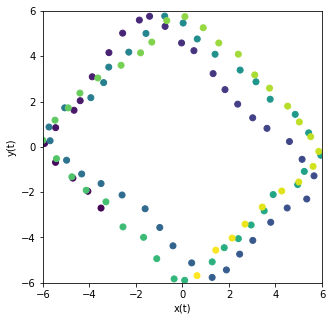

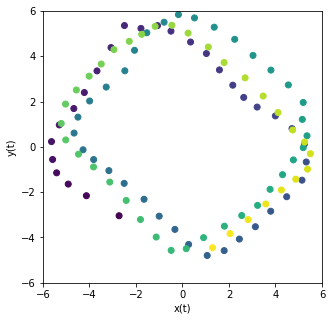

In [16]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)
    data_dicts = [data['position_%d' % t].unsqueeze(dim=0).detach()
                  for t in range(T)]

    diagram = training_model()
    diagram = conditioning.SequentialConditioner(step_state=data_dicts)(diagram)
    elbos = variational.infer(diagram, 2000, use_cuda=True, lr=1e-2, patience=100)
    
    utils.plot_evidence_bounds(elbos.detach().numpy(), True)
    
    graph = sampler.compile(diagram >> signal.Cap(diagram.cod))
    sampler.filter(graph)
    sampler.smooth(graph)
    p, log_weight = sampler.trace(graph)
    inferred_trajectory = accumulate_trajectory(p)

    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([p['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)

    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).unsqueeze(1).to(displacements), displacements[:-1]), dim=2)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).unsqueeze(1).to(displacements) + 1, displacements[:-1]), dim=2)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [17]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])
    print('Inferred position at time %d' % t, positions[:, t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[:, t])**2).sum())

Position at time 0 tensor([-3.5021, -2.6996])
Inferred position at time 0 tensor([[-2.7258, -3.0394]])
MSE at time 0 tensor(0.7180)
Position at time 1 tensor([-4.0682, -1.9584])
Inferred position at time 1 tensor([[-4.1309, -2.1557]])
MSE at time 1 tensor(0.0429)
Position at time 2 tensor([-4.7122, -1.3787])
Inferred position at time 2 tensor([[-4.9125, -1.6417]])
MSE at time 2 tensor(0.1093)
Position at time 3 tensor([-5.4583, -0.6825])
Inferred position at time 3 tensor([[-5.4115, -1.1443]])
MSE at time 3 tensor(0.2154)
Position at time 4 tensor([-5.9298,  0.1506])
Inferred position at time 4 tensor([[-5.5851, -0.5563]])
MSE at time 4 tensor(0.6185)
Position at time 5 tensor([-5.4542,  0.8492])
Inferred position at time 5 tensor([[-5.6320,  0.2339]])
MSE at time 5 tensor(0.4102)
Position at time 6 tensor([-4.6626,  1.6177])
Inferred position at time 6 tensor([[-5.2978,  0.9705]])
MSE at time 6 tensor(0.8224)
Position at time 7 tensor([-4.3980,  2.0399])
Inferred position at time 7 te

In [18]:
data

{'position_0': tensor([-3.5021, -2.6996]),
 'position_1': tensor([-4.0682, -1.9584]),
 'velocity_0': tensor([-0.5662,  0.7412]),
 'position_2': tensor([-4.7122, -1.3787]),
 'velocity_1': tensor([-0.6439,  0.5797]),
 'position_3': tensor([-5.4583, -0.6825]),
 'velocity_2': tensor([-0.7461,  0.6962]),
 'position_4': tensor([-5.9298,  0.1506]),
 'velocity_3': tensor([-0.4715,  0.8331]),
 'position_5': tensor([-5.4542,  0.8492]),
 'velocity_4': tensor([0.4756, 0.6986]),
 'position_6': tensor([-4.6626,  1.6177]),
 'velocity_5': tensor([0.7916, 0.7685]),
 'position_7': tensor([-4.3980,  2.0399]),
 'velocity_6': tensor([0.2646, 0.4221]),
 'position_8': tensor([-3.8798,  3.0958]),
 'velocity_7': tensor([0.5182, 1.0559]),
 'position_9': tensor([-3.1621,  4.1616]),
 'velocity_8': tensor([0.7177, 1.0659]),
 'position_10': tensor([-2.5723,  5.0225]),
 'velocity_9': tensor([0.5898, 0.8608]),
 'position_11': tensor([-1.8538,  5.5992]),
 'velocity_10': tensor([0.7186, 0.5768]),
 'position_12': tensor

In [23]:
torch.save(data, 'examples/dynamical_ball/dynamical_ball_data.pt')

In [24]:
for box in graph:
    if isinstance(box, sampler.ImportanceWiringBox):
        torch.save(box.target.state_dict(), 'examples/dynamical_ball/' + box.name + '_target.pt')
        torch.save(box.proposal.state_dict(), 'examples/dynamical_ball/' + box.name + '_proposal.pt')